# altimetry/gdp collocalisation

Database extension:

- [ ] add GPS-drifter collocations
- [ ] add another satellite
- [ ] extend to one year


To do:

- [ ] generate local rotated carthesian coordinates
- [ ] setup boxed lags (allow time lag on top of space one)
- [ ] setup AVISO interpolation


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

%matplotlib inline
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()

from xgcm import Grid
from xhistogram.xarray import histogram

import warnings
warnings.filterwarnings("ignore")

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=4, cores=4)
    w = cluster.scale(jobs=5)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

- `site_obs`: drifter time
- `sassa_time`: satellite time


In [3]:
nc = '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/mdb/2016/20161201_SASSA-L3-SLA-Sentinel-3_A__argos.nc'

dsuff = "argos_drifters"
asuff = "sassa"

ds = xr.open_dataset(nc).persist()
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

Dataset size = 1.0 GB


In [4]:
# add several variables in coords
ds = (ds
      .set_coords([dsuff+"_"+d for d in ["time", "lon", "lat"]])
      .set_coords([asuff+"_"+d for d in ["time_", "lon", "lat"]])
     )

### add local coordinates oriented along the altimetric track

In [5]:
def lonlat2xy(lonc, latc, lon1, lat1, lon, lat):
    """ return coordinates with origin at (lonc, latc) and x-axis aligned 
    with (lonc, latc) - (lon1, lat1) direction
    
    """

    proj = pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")
    # get local coordinate
    xc, yc = proj.transform(lonc, latc)
    x1, y1 = proj.transform(lon1, lat1)
    xl, yl = proj.transform(lon, lat)
    # get orientation of defined by central point and point 1
    phi = np.arctan2( y1-yc, x1-xc )*180/np.pi
    # build affine operators
    a_fwrd = Affine.translation(-xc, -yc) * Affine.rotation(-phi, pivot=(xc, yc))
    #a_back = ~a_fwrd
    
    x, y = a_fwrd * (xl, yl)
    
    return x, y

In [6]:
#_ds = ds.isel(obs=slice(1,100))
_ds = ds.isel(obs=slice(1,1000))

def compute_local_xy(ds, suff, asuff, tdim):

    i = (ds[asuff+"_time"].size-1)//2
    lonc = ds[asuff+"_lon"].isel(sassa_time=i)
    latc = ds[asuff+"_lat"].isel(sassa_time=i)
    lon1 = ds[asuff+"_lon"].isel(sassa_time=-1)
    lat1 = ds[asuff+"_lat"].isel(sassa_time=-1)
    lon = ds[suff+"_lon"]
    lat = ds[suff+"_lat"]

    # will need to vectorize with dask eventually
    x, y = xr.apply_ufunc(lonlat2xy,
                   lonc, latc,
                   lon1, lat1,
                   lon, lat,
                   input_core_dims = [[]]*4+[[tdim]]*2,
                   output_core_dims = [[tdim]]*2,
                   vectorize=True,
                  )
    return x, y


In [7]:
ds[dsuff+"_x"], ds[dsuff+"_y"] = compute_local_xy(ds, dsuff, asuff, "site_obs")
ds = ds.set_coords([dsuff+"_x", dsuff+"_y"])

ds[asuff+"_x"], ds[asuff+"_y"] = compute_local_xy(ds, asuff, asuff, asuff+"_time")
ds = ds.set_coords([asuff+"_x", asuff+"_y"])

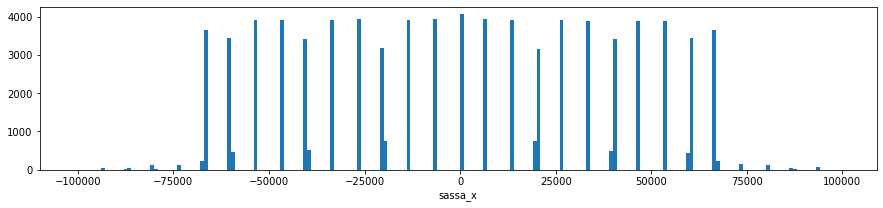

In [8]:
fig = plt.figure(figsize=(15,3))
bins=np.arange(-100e3,100e3,1e3)
ds[asuff+"_x"].plot.hist(bins=bins);
#ds[asuff+"_y"].plot.hist(bins=bins);

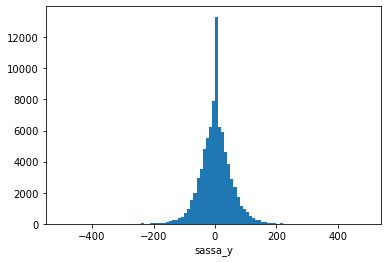

In [9]:
bins=np.arange(-5e2,5e2,1e1)
ds[asuff+"_y"].plot.hist(bins=bins);

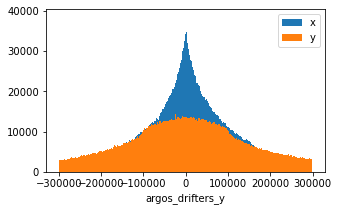

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
bins=np.arange(-300e3,300e3,1e3)
ds[dsuff+"_x"].plot.hist(bins=bins, label="x");
ds[dsuff+"_y"].plot.hist(bins=bins, label="y");
ax.legend()

### add along-track sla gradient

In [11]:
t = ds[asuff+"_time"]
tc = (t + t.shift({asuff+"_time": -1}))*0.5 # C
tc = tc[:-1].rename({asuff+"_time": asuff+"_time_mid"})

ds = ds.assign_coords(**{asuff+"_time": t, asuff+"_time_mid": tc})
grid = Grid(ds, coords={"t": {"center": "sassa_time_mid", "outer": "sassa_time"}})

ds[asuff+"_x_mid"] = grid.interp(ds[asuff+"_x"], axis="t")
ds[asuff+"_y_mid"] = grid.interp(ds[asuff+"_y"], axis="t")
ds = ds.set_coords([asuff+"_x_mid", asuff+"_y_mid"])

In [13]:
#dt = grid.diff(ds[asuff+"_time_"], axis="t")/pd.Timedelta("1S")
dx = grid.diff(ds[asuff+"_x"], axis="t")
dy = grid.diff(ds[asuff+"_y"], axis="t")
dxy = np.sqrt(dx**2+dy**2)

g = 9.81
dsla = grid.diff(ds[asuff+"_sla"], axis="t")
ds["g_grad_sla"] = g*dsla/dxy

dsla = grid.diff(ds[asuff+"_sla_denoised"], axis="t")
ds["g_grad_sla_denoised"] = g*dsla/dxy

# add Coriolis frequency
ds["f"] = 2 *2*np.pi/86164.1 * np.sin(ds.lat*np.pi/180)

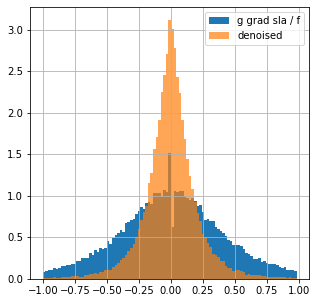

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
bins=np.arange(-1,1,.02)
(ds["g_grad_sla"]/ds.f).plot.hist(bins=bins, density=True, label="g grad sla / f")
(ds["g_grad_sla_denoised"]/ds.f).plot.hist(bins=bins, density=True, label="denoised", alpha=.7)

ax.legend()
ax.grid()

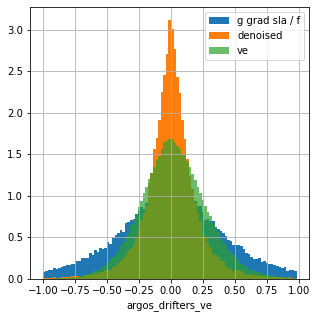

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
bins=np.arange(-1.,1.,.02)
(ds["g_grad_sla"]/ds.f).plot.hist(bins=bins, density=True, label="g grad sla / f")
(ds["g_grad_sla_denoised"]/ds.f).plot.hist(bins=bins, density=True, label="denoised")
ds[dsuff+"_ve"].plot.hist(bins=bins, density=True, label="ve", alpha=.7)
#ds[dsuff+"_vn"].plot.hist(bins=bins, density=True, label="vn", alpha=.7)

ax.legend()
ax.grid()

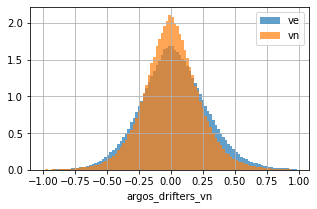

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
bins=np.arange(-1,1,.02)
ds[dsuff+"_ve"].plot.hist(bins=bins, density=True, label="ve", alpha=.7)
ds[dsuff+"_vn"].plot.hist(bins=bins, density=True, label="vn", alpha=.7)

ax.legend()
ax.grid()

---

## global overview

In [18]:
t_max = pd.to_datetime(ds.time.max().values)
t_min = pd.to_datetime(ds.time.min().values)
print(f" {t_min} to {t_min}, {t_max-t_min}")

 2016-11-30 22:00:00 to 2016-11-30 22:00:00, 31 days 01:00:00


### overview map

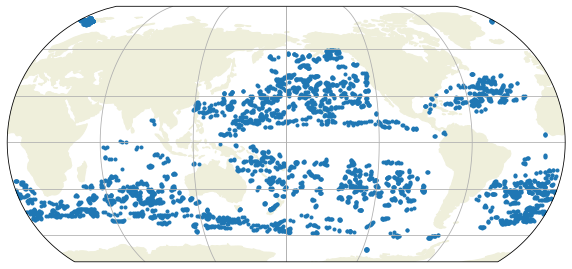

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.EckertIII(central_longitude=-180))

land_feature = cfeature.LAND
ax.add_feature(land_feature, zorder=2)

#for o in ds.obs:
#    _ds = ds.sel(obs=o)
#    ax.plot(_ds.sassa_lon, _ds.sassa_lat, color="0.9", transform=ccrs.PlateCarree())

ax.plot(ds.lon, ds.lat, ".", transform=ccrs.PlateCarree())

gl = ax.gridlines()

### count occurences in bins

(array([  0., 497., 385., 224., 159.,  73.,  46.,  26.,  13.,  17.,   8.,
          3.,   0.,   1.,   1.,   2.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <BarContainer object of 19 artists>)

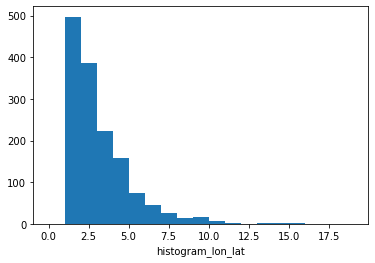

In [20]:
dl = 2
lon, lat = np.arange(-180, 180, dl), np.arange(-90,90,dl)

count = histogram(ds.lon, ds.lat, bins=[lon, lat], bin_dim_suffix='')
count = count.where(count>0)
count.plot.hist(bins=np.arange(0,20))

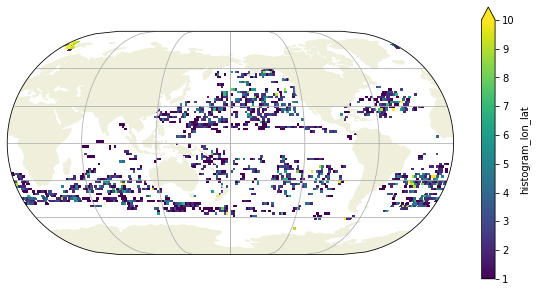

In [21]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.EckertIII(central_longitude=-180))

land_feature = cfeature.LAND
ax.add_feature(land_feature, zorder=2)

count.plot(x="lon", y="lat", ax=ax,
           vmax = 10,
           transform=ccrs.PlateCarree())

#ax.plot(ds.lon, ds.lat, ".", transform=ccrs.PlateCarree())

gl = ax.gridlines()

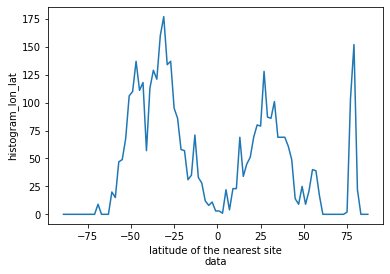

In [22]:
count.sum("lon").plot()

## separation statistics

(array([627., 678., 638., 730., 633., 498.,  75.,  21.,  11.,  13.,   9.,
          7.,   8.,  16.,  10.,   7.,   8.,   8.,   8.,  12.,  10.,   9.,
          7.,   3.,   3.,   2.,   1.,   1.,   0.,   1.]),
 array([8.000000e+01, 1.769420e+04, 3.530840e+04, 5.292260e+04,
        7.053680e+04, 8.815100e+04, 1.057652e+05, 1.233794e+05,
        1.409936e+05, 1.586078e+05, 1.762220e+05, 1.938362e+05,
        2.114504e+05, 2.290646e+05, 2.466788e+05, 2.642930e+05,
        2.819072e+05, 2.995214e+05, 3.171356e+05, 3.347498e+05,
        3.523640e+05, 3.699782e+05, 3.875924e+05, 4.052066e+05,
        4.228208e+05, 4.404350e+05, 4.580492e+05, 4.756634e+05,
        4.932776e+05, 5.108918e+05, 5.285060e+05]),
 <BarContainer object of 30 artists>)

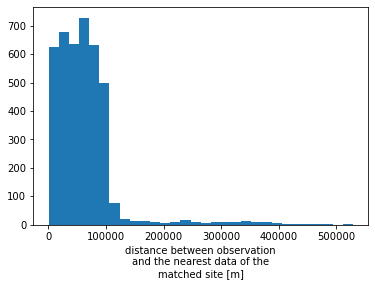

In [23]:
ds[asuff+"___distance"].plot.hist(bins=30)

---

## focus on on a single matchup

In [24]:
i = 0
_ds = ds.isel(obs=0)

lon, lat, t = float(_ds.lon), float(_ds.lat), _ds.time.values
td = pd.to_datetime(t)
dt = float(_ds[asuff+"___time_difference"])
dl = float(_ds[asuff+"___distance"])

a_deltat = float((_ds[asuff+"_time_"].max() - _ds[asuff+"_time_"].min())
                 /pd.Timedelta("1S")
                )

_dsm = _ds.isel(site_obs=_ds.__site_matchup_indice)


print(f" time difference = {dt/60:.1f} minutes")
print(f" separation = {dl/1e3:.1f} km")
print(f" satellite pass length = {a_deltat:.1f} seconds")


 time difference = 18.6 minutes
 separation = 92.7 km
 satellite pass length = 20.0 seconds


### overview map


Text(0.5, 1.0, 'dl=92.7km , dt=18.6min , 2016/12/01 04:00')

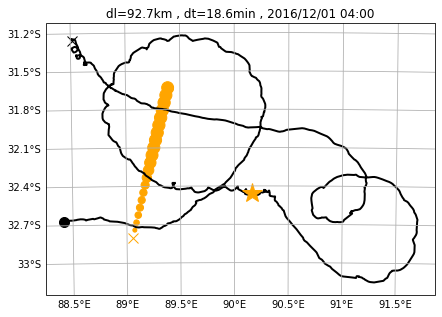

In [25]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))

land_feature = cfeature.LAND
ax.add_feature(land_feature, zorder=2)

# drifter
ax.plot(_ds[dsuff+"_lon"], _ds[dsuff+"_lat"], color="k", lw=2, transform=crs)
ax.plot(_ds[dsuff+"_lon"][0], _ds[dsuff+"_lat"][0], "o", ms=10, color="k", transform=crs)
ax.plot(_ds[dsuff+"_lon"][-1], _ds[dsuff+"_lat"][-1], "x", ms=10, color="k", transform=crs)

ax.plot(_dsm[dsuff+"_lon"], _dsm[dsuff+"_lat"], 
        "*", ms=20, color="orange", lw=2, transform=crs)

# altimetry
#ax.plot(_ds[asuff+"_lon"], _ds[asuff+"_lat"], color="orange", lw=2, transform=crs)
_sla = _ds[asuff+"_sla_denoised"]
_sla = _sla - _sla.min()
ax.scatter(_ds[asuff+"_lon"], _ds[asuff+"_lat"], s=_sla*1000, color="orange", transform=crs)
ax.plot(_ds[asuff+"_lon"][0], _ds[asuff+"_lat"][0], "o", ms=10, color="orange", transform=crs)
ax.plot(_ds[asuff+"_lon"][-1], _ds[asuff+"_lat"][-1], "x", ms=10, color="orange", transform=crs)

gl = ax.gridlines(draw_labels=True, dms=False, 
             x_inline=False, y_inline=False, 
            )
gl.right_labels=False
gl.top_labels=False

ax.set_title(f"dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , "+td.strftime("%Y/%m/%d %H:%M"))

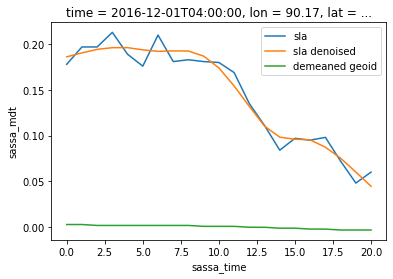

In [27]:
fig, ax = plt.subplots(1,1)
_ds.sassa_sla.plot(label="sla")
_ds.sassa_sla_denoised.plot(label="sla denoised")
(_ds.sassa_mdt-_ds.sassa_mdt.mean()).plot(label="demeaned geoid")
ax.legend()

---
## box stats



In [35]:
dx = 1e3
x, y = np.arange(-100e3, 100e3, dx), np.arange(-100e3,100e3, dx)

_ds = ds.isel(site_obs=_ds.__site_matchup_indice)

count = histogram(_ds[dsuff+"_x"], _ds[dsuff+"_y"], 
                  bins=[x, y], bin_dim_suffix='')
count = count.where(count>0)

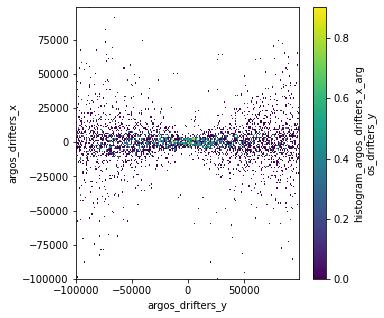

In [37]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
np.log10(count).plot()

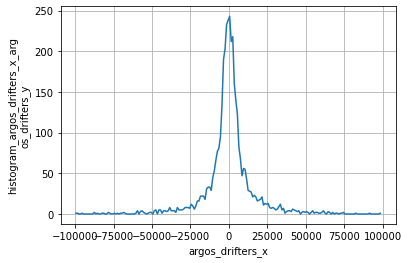

In [41]:
fig, ax = plt.subplots(1,1)
count.sum(dsuff+"_y").plot()
ax.grid()

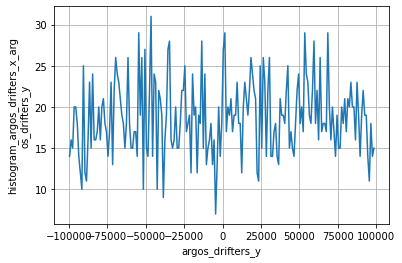

In [42]:
fig, ax = plt.subplots(1,1)
count.sum(dsuff+"_x").plot()
ax.grid()